# Setup

## Colab

In [1]:
# # # Mount the drive and move to dir
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [1]:
# Switch to current dir
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os
import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the utilities and the dataloader
from utils import trainutil, inferutil, setuputil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)

# Import the funcs needed from utils
from utils.setuputil import setup_config, display_config
from utils.trainutil import train_unified
from utils.inferutil import infer_one, infer_full, binfer_one, binfer_full

## Configuration

In [3]:
input_config = {
    # Environment and Model Info
    "env": "colab",
    "approach": "bert",
    "model_name": "BertBase",
    "model_base": "bert-base-cased",
    # System Configuration
    "device": "cuda:0",
    "threads": 10,
    "seed": 0,
    # Data Configuration
    "data_dir": "../data",
    "data_ds": "manual",
    # Model Parameters
    "rows": 100,
    "cols": 100,
    "tokens": 32,
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 128,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 512,
    # Training Parameters
    "batch_size": 12,
    "lr": 1e-3,
    "mu": 0.25,
    "epochs": 10,
    "patience": 2,
    "save_int": 0,
    "save_dir": "../models/",
}
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 40/40 [00:10<00:00,  3.95it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3226.39it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 2800.31it/s]



5(P) = 5(G) + 0(E)
{
  "env": "colab",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 10,
  "seed": 0,
  "model_base": "bert-base-cased",
  "model_name": "BertBase",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 128,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 512,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 12,
  "lr": 0.001,
  "mu": 0.25,
  "epochs": 10,
  "patience": 2,
  "save_

# Model Creation

In [4]:
from transformers import BertModel, BertConfig
import torch.nn as nn
import torch
import math
from tqdm import tqdm


class SimpleBertEmbedAvg(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Define all params from config
        self.vocab_size = config["vocab_size"]
        self.hidden_size = config["hidden_size"]
        self.intermediate_size = config["intermediate_size"]
        self.num_hidden_layers = config["num_hidden_layers"]
        self.num_attention_heads = config["num_attention_heads"]
        self.hidden_act = config["hidden_act"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]
        self.attention_probs_dropout_prob = config["attention_probs_dropout_prob"]
        self.max_position_embeddings = config["max_position_embeddings"]
        self.type_vocab_size = config["type_vocab_size"]
        self.layer_norm_eps = config["layer_norm_eps"]
        self.initializer_range = config["initializer_range"]
        self.pad_token_id = config["pad_token_id"]
        self.gradient_checkpointing = config["gradient_checkpointing"]

        # Setup config with all params
        self.config = BertConfig(
            vocab_size=self.vocab_size,
            hidden_size=self.hidden_size,
            num_hidden_layers=self.num_hidden_layers,
            num_attention_heads=self.num_attention_heads,
            intermediate_size=self.intermediate_size,
            hidden_act=self.hidden_act,
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=self.attention_probs_dropout_prob,
            max_position_embeddings=self.max_position_embeddings,
            type_vocab_size=self.type_vocab_size,
            layer_norm_eps=self.layer_norm_eps,
            initializer_range=self.initializer_range,
            pad_token_id=self.pad_token_id,
            gradient_checkpointing=self.gradient_checkpointing,
        )

        # Create BERT model from scratch (no pretrained weights)
        self.bert = BertModel(self.config)

        # Simple classification head with dropout from config
        self.dropout = nn.Dropout(self.hidden_dropout_prob)
        self.gelu = nn.GELU()
        self.classifier = nn.Linear(self.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        batch_size, rows, cols, seq_len = input_ids.shape
        S_cube = torch.zeros((batch_size, rows, cols), device=input_ids.device)

        # Process each cell with progress bar
        for cell in range(rows * cols):
            row = cell // cols
            col = cell % cols

            # Simple forward pass
            outputs = self.bert(
                input_ids=input_ids[:, row, col, :],
                attention_mask=attention_mask[:, row, col, :],
            )

            pooled = self.dropout(outputs.pooler_output)
            activated = self.gelu(pooled)
            logits = self.classifier(activated)
            S_cube[:, row, col] = logits.squeeze(-1)

        return S_cube

In [5]:
# 1) Create model and move to GPU Observe its architecture - 440 Mib
untrained_model = SimpleBertEmbedAvg(config).to(DEVICE)
print(untrained_model)

SimpleBertEmbedAvg(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(64, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_aff

# Model Training

In [6]:
# Train with adjusted batch size
trained_model = train_unified(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
)

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.11s/it]


Train Loss: 1.38031667470932, Perplexity: 1.0000460116143255
Val Loss: 1.3106958866119385, Perplexity: 1.000043690817303


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.09s/it]


Train Loss: 1.2279228270053864, Perplexity: 1.0000409315985752
Val Loss: 0.9257234930992126, Perplexity: 1.0000308579258659


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.16s/it]


Train Loss: 0.818971186876297, Perplexity: 1.0000272994121848
Val Loss: 0.5516822934150696, Perplexity: 1.0000183895788668


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.26s/it]


Train Loss: 0.5450553968548775, Perplexity: 1.000018168678277
Val Loss: 0.36260026693344116, Perplexity: 1.0000120867486086


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.19s/it]


Train Loss: 0.38567692786455154, Perplexity: 1.0000128559802328
Val Loss: 0.2564084529876709, Perplexity: 1.0000085469849582


Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.32s/it]


Train Loss: 0.29277998954057693, Perplexity: 1.0000097593806072
Val Loss: 0.2134334295988083, Perplexity: 1.000007114472961


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.38s/it]


Train Loss: 0.2393132634460926, Perplexity: 1.0000079771405987
Val Loss: 0.18203921616077423, Perplexity: 1.0000060679922822


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.39s/it]


Train Loss: 0.20458701625466347, Perplexity: 1.000006819590462
Val Loss: 0.14917510747909546, Perplexity: 1.0000049725159454


Epoch 8


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.36s/it]


Train Loss: 0.17129746824502945, Perplexity: 1.0000057099319097
Val Loss: 0.1285134106874466, Perplexity: 1.0000042837895315


Epoch 9


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.10s/it]


Train Loss: 0.15350934118032455, Perplexity: 1.000005116991131
Val Loss: 0.11483192443847656, Perplexity: 1.0000038277381404



TRAINING DONE at epoch 9, best epoch 9
Train Loss = 0.15350934118032455, Perplexity = 1.000005116991131
Val Loss = 0.11483192443847656, Perplexity = 1.0000038277381404



Filename: ../data/manual_train/portfoliobyloanstatus copy.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(4,10): 0.95858633518218994141
(7,1): 0.95914387702941894531
(4,12): 0.95916396379470825195
(4,4): 0.95922029018402099609
(16,0): 0.95922106504440307617
(9,1): 0.95922458171844482422
(20,0): 0.95922851562500000000
(6,0): 0.95923030376434326172
(24,0): 0.95923697948455810547
(32,0): 0.95923829078674316406
(8,0): 0.95924150943756103516
(4,14): 0.95924586057662963867
(12,0): 0.95925796031951904297
(28,0): 0.95926922559738159180
(36,0): 0.95934230089187622070
(6,1): 0.95936226844787597656
(8,1): 0.95936995744705200195
(4,6): 0.95940756797790527344
(37,1): 0.95949834585189819336
(38,0): 0.95952159166336059570
(5,3): 0.95954334735870361328
(0,0): 0.95956528186798095703
(5,0): 0.95963215827941894531
(5,2): 0.95963221788406372070
(4,2): 0.95966595411300659180
(4,8): 0.95967781543731689453

NB to B ratio: Predicted = 9879:121 | Actual = 9874:126
Accuracy: 99.81% | Precision: 94.21

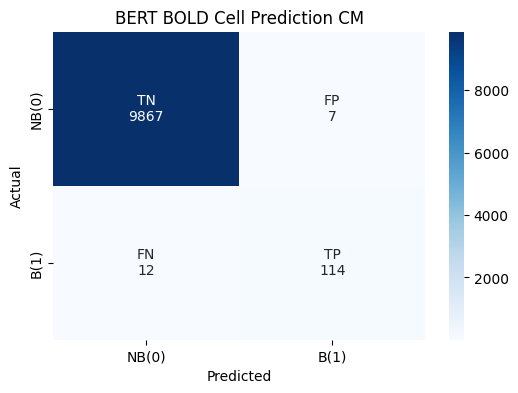


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# Params
loc = 0
thresh = 0.95922
cond = '>'
disp_max=True

# inference on single position of train loader params
binfer_one(
    trained_model,
    train_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../data/manual_val/ffelbydefermenttype.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(0,0): 0.94065713882446289062
(10,1): 0.95914387702941894531
(5,4): 0.95919060707092285156
(11,0): 0.95922106504440307617
(8,1): 0.95922458171844482422
(5,10): 0.95922589302062988281
(15,0): 0.95922851562500000000
(19,0): 0.95923697948455810547
(27,0): 0.95923829078674316406
(5,14): 0.95924586057662963867
(7,0): 0.95925796031951904297
(23,0): 0.95926922559738159180
(5,12): 0.95933902263641357422
(31,0): 0.95934230089187622070
(5,8): 0.95934689044952392578
(5,6): 0.95935600996017456055
(9,1): 0.95936226844787597656
(7,1): 0.95936995744705200195
(5,2): 0.95938235521316528320
(6,3): 0.95954334735870361328
(6,0): 0.95963215827941894531
(6,2): 0.95963221788406372070
(5,16): 0.95967251062393188477

NB to B ratio: Predicted = 9922:78 | Actual = 9896:104
Accuracy: 99.74% | Precision: 100.00% | Recall: 75.00% | F1-Score: 0.86



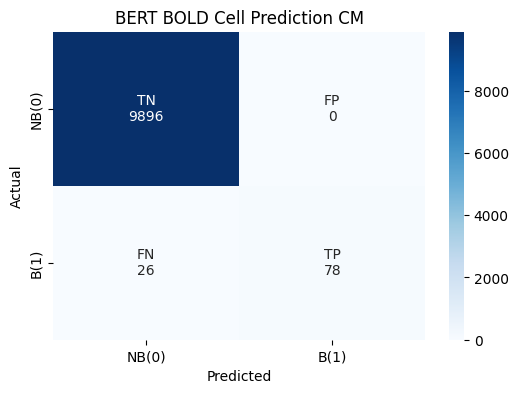


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
5,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
binfer_one(
    trained_model,
    val_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../data/manual_test/dlportfoliobyrepaymentplan.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(5,2): 0.70479935407638549805
(5,4): 0.77071142196655273438
(5,16): 0.88698470592498779297
(5,14): 0.94923776388168334961
(5,6): 0.95892786979675292969
(5,8): 0.95894926786422729492
(8,1): 0.95914387702941894531
(5,12): 0.95918267965316772461
(5,18): 0.95918369293212890625
(17,0): 0.95922106504440307617
(10,1): 0.95922458171844482422
(21,0): 0.95922851562500000000
(7,0): 0.95923030376434326172
(25,0): 0.95923697948455810547
(33,0): 0.95923829078674316406
(9,0): 0.95924150943756103516
(5,20): 0.95924586057662963867
(13,0): 0.95925796031951904297
(29,0): 0.95926922559738159180
(5,10): 0.95930016040802001953
(37,0): 0.95934230089187622070
(7,1): 0.95936226844787597656
(9,1): 0.95936995744705200195
(0,0): 0.95948439836502075195
(6,3): 0.95954334735870361328
(6,0): 0.95963215827941894531
(6,2): 0.95963221788406372070

NB to B ratio: Predicted = 9893:107 | Actual = 9872:128
Accu

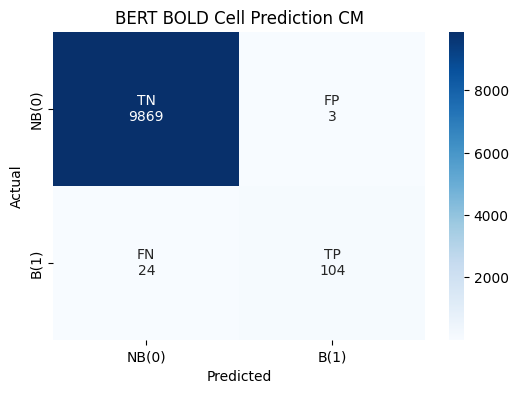


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
binfer_one(
    trained_model,
    test_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)

Batch Inference: 100%|██████████| 2/2 [00:32<00:00, 16.08s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 396886:3114 | Actual = 396714:3286
Accuracy: 99.89% | Precision: 96.08% | Recall: 90.92% | F1-Score: 0.93



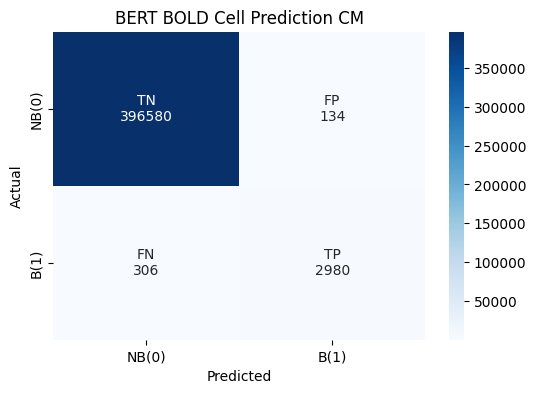

In [23]:
binfer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=20,
    threshold=thresh,
    device=DEVICE
)

Batch Inference: 100%|██████████| 1/1 [00:15<00:00, 15.87s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49635:365 | Actual = 49602:398
Accuracy: 99.91% | Precision: 98.36% | Recall: 90.20% | F1-Score: 0.94



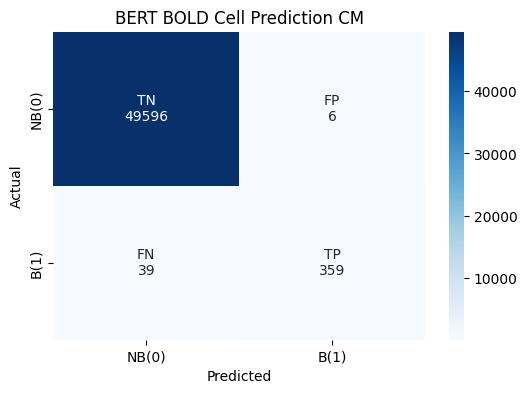

In [24]:
binfer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=10,
    threshold=thresh,
    device=DEVICE
)

Batch Inference: 100%|██████████| 1/1 [00:15<00:00, 15.83s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49641:359 | Actual = 49606:394
Accuracy: 99.91% | Precision: 98.33% | Recall: 89.59% | F1-Score: 0.94



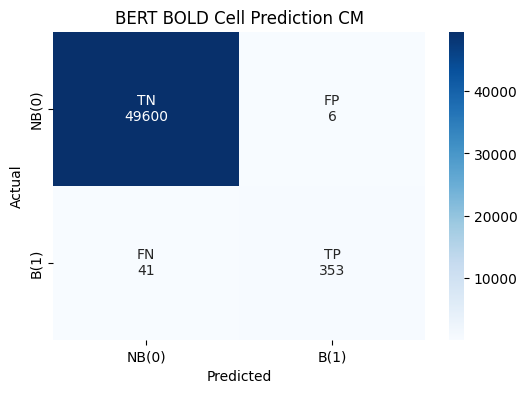

In [25]:
binfer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=10,
    threshold=thresh,
    device=DEVICE
)